
# Gait Sequence Detection

This example can be referenced by citing the package.

The example illustrates how the gait sequence detection (GSDB) algorithm is used to detect gait sequences using body acceleration recorded with a triaxial accelerometer worn or fixed on the lower back. The gait sequence detection algorithm is implemented in the main module `NGMT\ngmt\modules\gsd\GSDB.py`.

The algorithm detects gait sequences based on identified steps. It starts by loading the accelerometer data, which includes three columns corresponding to the acceleration signals across the x, y, and z axes, along with the sampling frequency of the data. To simplify the analysis, the norm of acceleration across the x, y, and z axes is computed. Next, the signal is resampled at a 40 Hz sampling frequency using interpolation. Smoothing is then applied through a Savitzky-Golay filter and a Finite Impulse Response (FIR) low-pass filter to remove noise and drifts from the signal. The continuous wavelet transform is applied to capture gait-related features, followed by additional smoothing using successive Gaussian-weighted filters. The processed data is then analyzed to detect gait sequences.

The algorithm continues by identifying the envelope of the processed acceleration signal. Active periods of the signal are identified using the Hilbert envelope. The statistical distribution of the amplitude of the peaks in these active periods is used to derive an adaptive threshold. In case the Hilbert envelope algorithm fails to detect active periods, a fixed threshold value (0.15 g) is used for peak detection in the signal. Mid-swing peaks are detected based on this threshold. Pulse trains in the local maximum and minimum of the peaks are identified, with those having fewer than four steps filtered out. The intersection of pulse trains from local maximum and minimum peaks is detected as walking periods. These periods are then organized and grouped to update the start and end times of detected walking bouts.

Finally, the algorithm takes the last steps to detect walking bouts in the signal. For this purpose, walking bouts with five or more steps are detected, and their start and end times are added to the list. Walking labels are generated as an array of zeros, and the intervals corresponding to the walking bouts are labeled as 1. Groups of consecutive zeros in the walking labels are identified, and if breaks between walking bouts are less than three seconds, they are merged. The output is then constructed as a list of dictionaries containing the start and end times of detected gait sequences. If gait sequences are found, the output is printed; otherwise, a message indicating that no gait sequences are detected is displayed.

## Import libraries
The necessary libraries such as numpy, matplotlib.pyplot, dataset (mobilised), and gait sequence detection module (GSDB) are imported. Make sure that you have all the required libraries and modules installed before running this code. You also may need to install the 'ngmt' library and its dependencies if you haven't already.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from ngmt.datasets import mobilised
from ngmt.modules.gsd import GSDB

## Data Preparation

To implement the GSDB algorithm, we load example data from a congestive heart failure (CHF) cohort, which is publicly available on the Zenodo repository [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.7547125.svg)](https://doi.org/10.5281/zenodo.7547125). 

The participant was assessed for 2.5 hours in the real-world while doing different daily life activities and also was asked to perform specific tasks such as outdoor walking, walking up and down a slope and stairs and moving from one room to another [`1`].

Since we will use norm of the accleration signal to detect gait sequences, we don't need to take care of orientation of the signal.

Refertences

.. [`1`] Mazzà, Claudia, et al. "Technical validation of real-world monitoring of gait: a multicentric observational study." BMJ open 11.12 (2021): e050785. http://dx.doi.org/10.1136/bmjopen-2021-050785


## Visualisation of the Data
The raw acceleration data including components of x, y and z axis is represented.

In [10]:
# This code snippet loads motion data from a MATLAB file
# The 'file_path' variable holds the absolute path to the data file
# The 'mobilised.load_file' function is used to load the data from the specified file
file_path = r'C:\Users\Project\Desktop\Mobilise-D dataset_1-18-2023\CHF\data.mat'
motion_data = mobilised.load_file(file_path=file_path)

In [11]:
# Get the recording data
# The 'motion_data' object contains recorded motion data. We're interested in a single tracked point (lower back).

# Since we only have a single tracked point (lower back)
# The recorded data is organized by tracked points. Here, we access the data for the lower back, which is typically at index 0.
recording_data = motion_data.data[0]

# Select only accelerometer data
# We are interested in the accelerometer data, so we need to identify the relevant channels.
# We'll identify accelerometer channels based on their names.

# Create a list of indices (idx_sel) for the accelerometer channels by iterating through the channel names.
idx_sel = [idx for idx, ch_name in enumerate(recording_data.channels.name)
           if "ACCEL" in ch_name]

# Extract the accelerometer data from the recording data
# We use the 'idx_sel' list to select the corresponding columns from the data.
acceleration_data = recording_data.data[:, idx_sel]

# Get the corresponding sampling frequency
# The 'recording_data' object contains information about the recorded data, including its sampling frequency.
sampling_frequency = recording_data.sampling_frequency

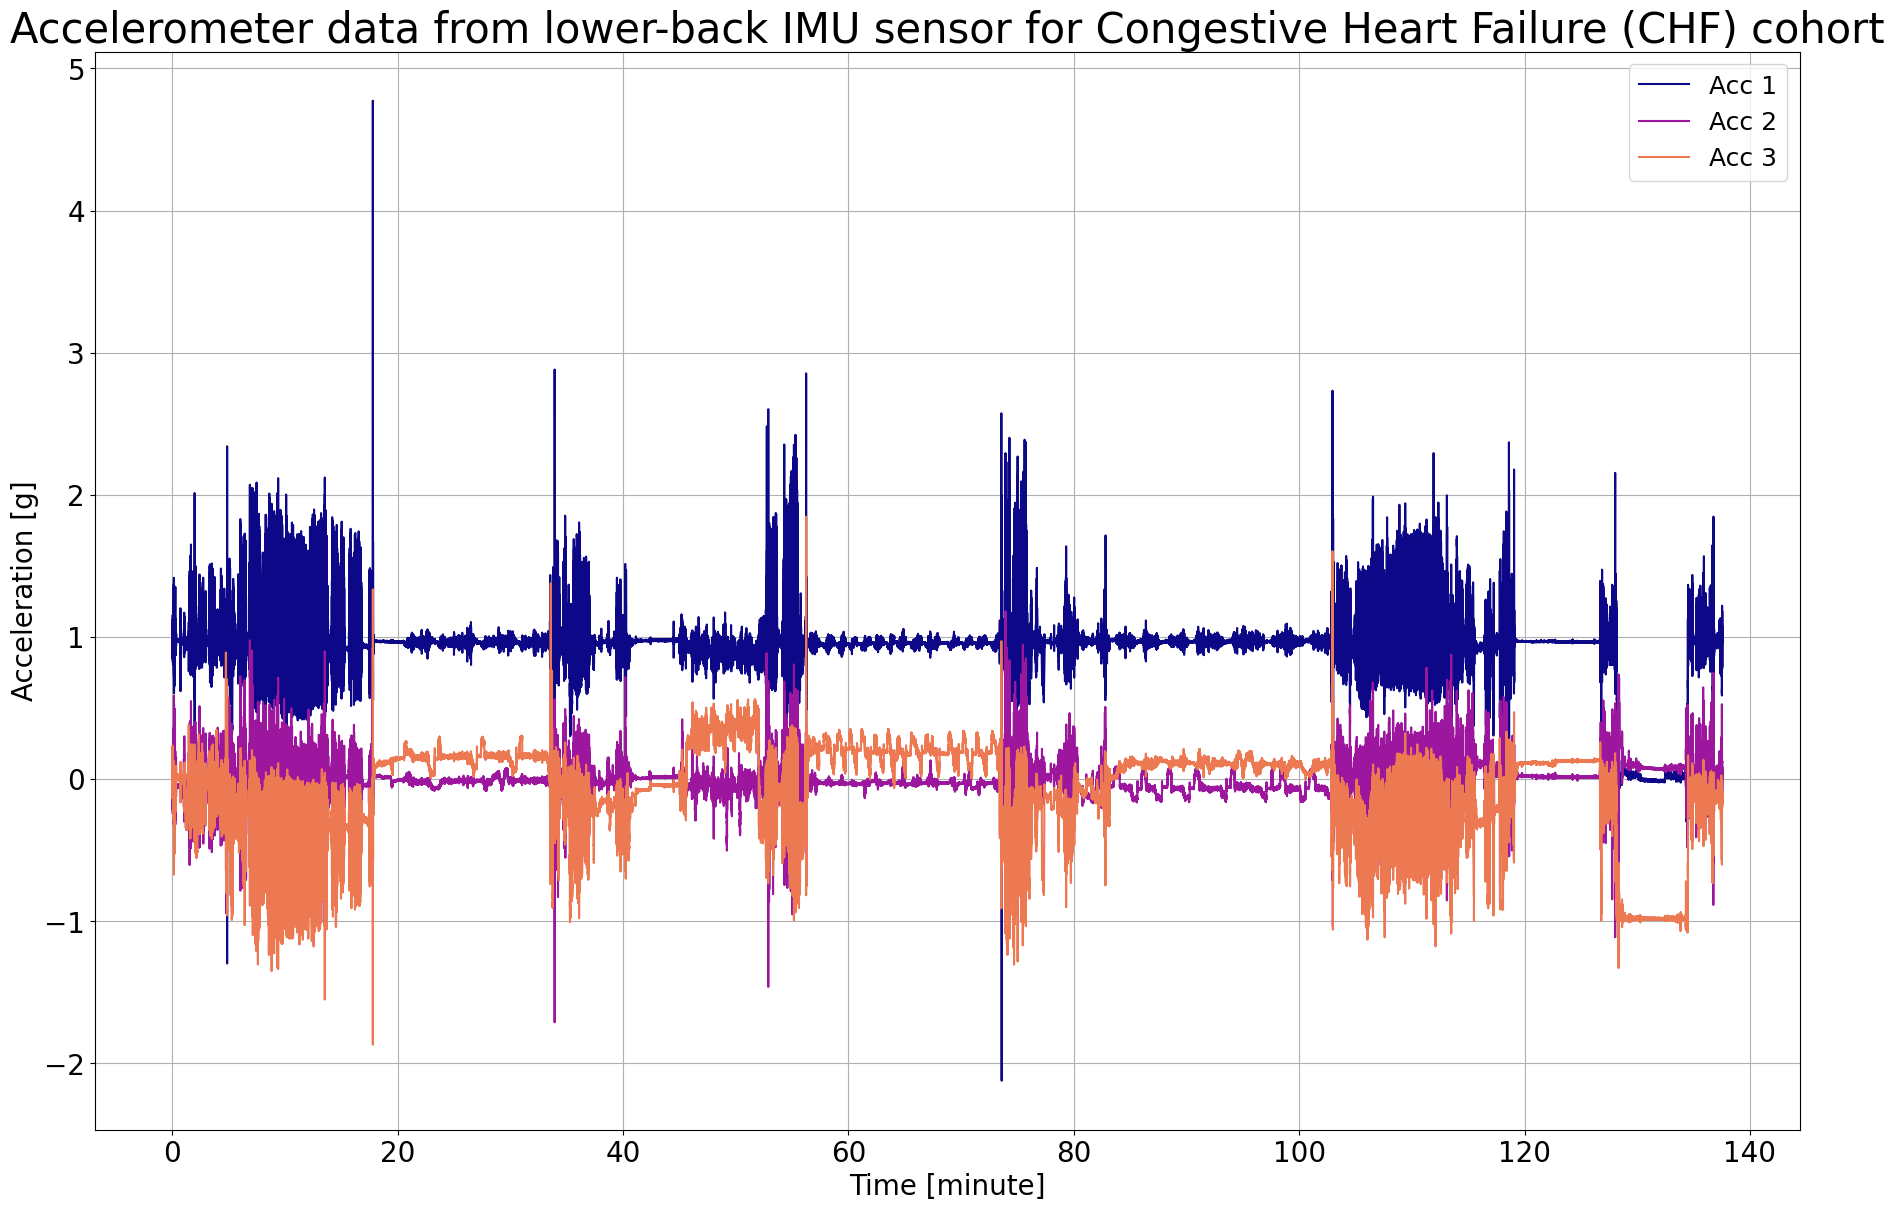

In [12]:
# Calculate the time values in minutes
# The 'time_in_minute' array represents time values in minutes, computed based on the length of 'acceleration_data' and 'sampling_frequency'.
time_in_minute = np.arange(len(acceleration_data)) / (60 * sampling_frequency)

# Create a figure with a specified size
plt.figure(figsize=(22, 14))

# Define the plasma color map
# We select the 'plasma' color map to have consistent colors representing similar data.
cmap = plt.get_cmap('plasma')

# A loop is used to plot data for each accelerometer axis, applying different colors from the color map.
for i in range(3):
    plt.plot(time_in_minute, acceleration_data[:, i], color=cmap(i/3), label=f'Acc {i + 1}')

# Add labels and legends
plt.xlabel("Time [minute]", fontsize=20)  
plt.ylabel("Acceleration [g]", fontsize=20)  
plt.legend(fontsize=18) 

# Add a title with a specified font size
plt.title("Accelerometer data from lower-back IMU sensor for Congestive Heart Failure (CHF) cohort", fontsize=30)

# Customize tick font sizes
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20)  #

# Display a grid for reference
plt.grid(visible=None, which='both', axis='both') 

# Show the plot
plt.show() 

Let's zoom in on specific time periods in the data, particularly the first 10 seconds, where clear blinks are evident.

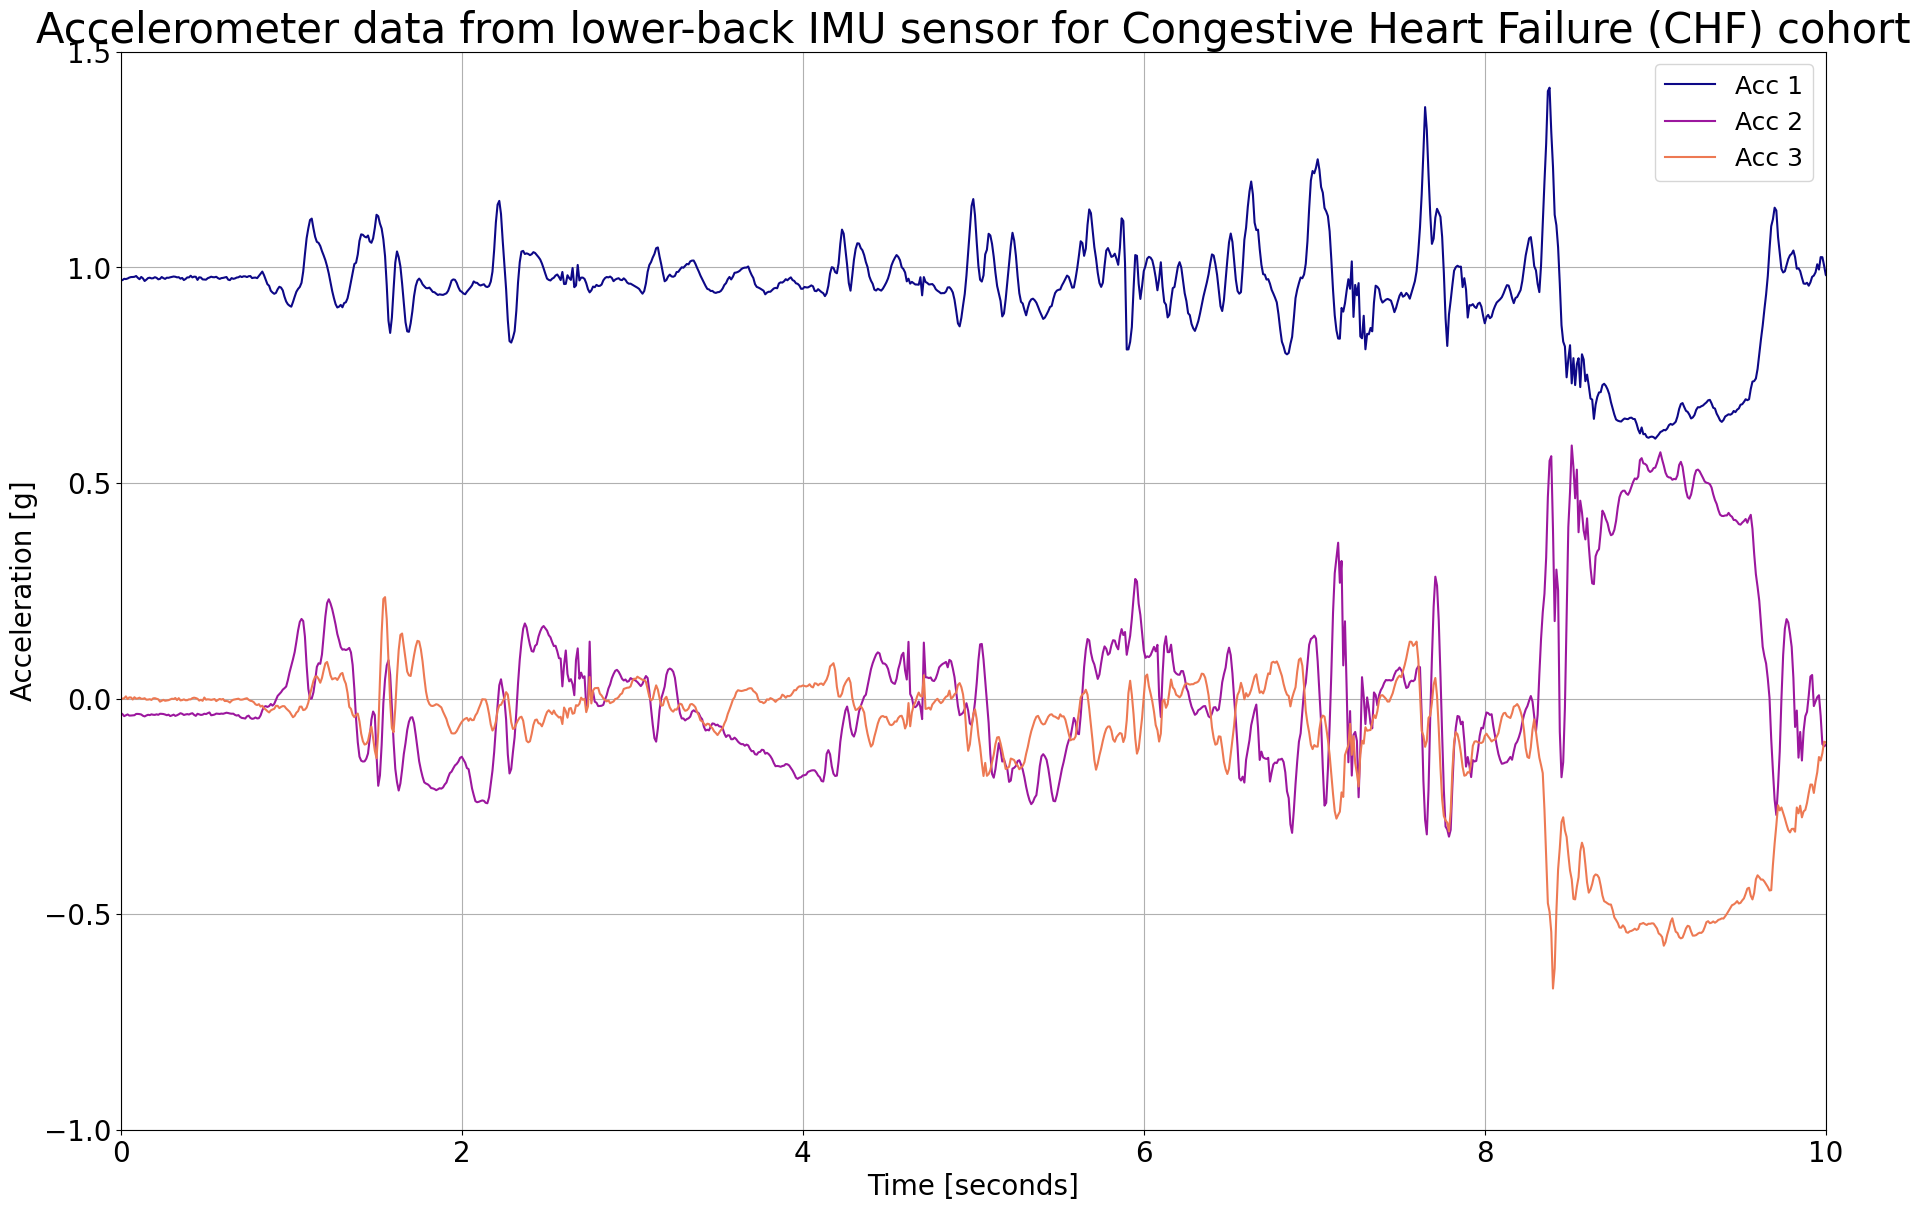

In [13]:
# Calculate the time values based on the length of the data
num_samples = len(acceleration_data)
time_seconds = np.arange(num_samples) / sampling_frequency

# Create a figure with the specified size
plt.figure(figsize=(22, 14))

# Plot acceleration data for each axis with time on the x-axis
for i in range(3):
    plt.plot(time_seconds, acceleration_data[:, i], color=plt.cm.plasma(i / 3), label=f'Acc {i + 1}')

# Add labels and legends
plt.xlabel("Time [seconds]", fontsize=20)
plt.ylabel("Acceleration [g]", fontsize=20)
plt.legend(fontsize=18)

# Add a title
plt.title("Accelerometer data from lower-back IMU sensor for Congestive Heart Failure (CHF) cohort", fontsize=30)

# Customize font sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Set x-axis and y-axis limits for a specific duration (in seconds) and acceleration range
plt.xlim(0, 10)
plt.ylim(-1, 1.5)

# Display a grid for reference
plt.grid(visible=None, which='both', axis='both')  # Add a grid for reference

# Show the plot
plt.show() 

## Applying the gait sequence detection algorithm
Now, we are running gait sequence detection (GSD) algorithm from main module (`NGMT.ngmt.modules.gsd.GSDB.Gait_Sequence_Detection`).  The inputs consist of accelerometer data (N, 3) for the x, y, and z axes, the initial sampling frequency of the data, and a plot option. Optionally, if the plot_results flag is set to True, a visualization plot is generated to display the preprocessed data and the detected gait sequences.

The start and end times are represented with vertical green and red lines, respectively. The grey area between the start and end times represents the gait sequence detected by the algorithm.

Gait sequence(s) detected.


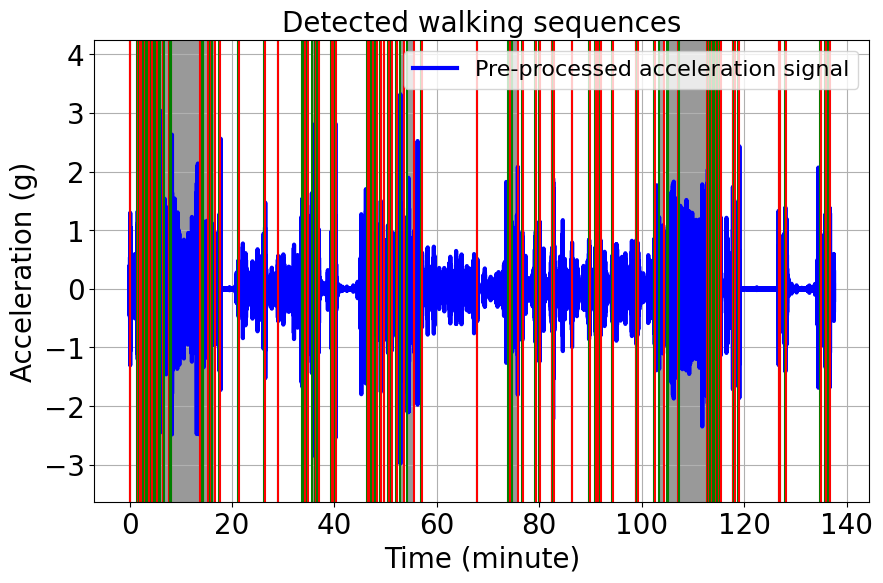

Gait Sequence:
Start Time: 4.5 seconds
End Time: 9.75 seconds
Gait Sequence:
Start Time: 90.225 seconds
End Time: 100.525 seconds
Gait Sequence:
Start Time: 106.075 seconds
End Time: 111.675 seconds
Gait Sequence:
Start Time: 116.225 seconds
End Time: 126.575 seconds
Gait Sequence:
Start Time: 141.275 seconds
End Time: 147.125 seconds
Gait Sequence:
Start Time: 159.525 seconds
End Time: 166.325 seconds
Gait Sequence:
Start Time: 174.275 seconds
End Time: 178.75 seconds
Gait Sequence:
Start Time: 195.1 seconds
End Time: 202.05 seconds
Gait Sequence:
Start Time: 207.3 seconds
End Time: 225.175 seconds
Gait Sequence:
Start Time: 256.925 seconds
End Time: 262.825 seconds
Gait Sequence:
Start Time: 291.225 seconds
End Time: 307.775 seconds
Gait Sequence:
Start Time: 315.475 seconds
End Time: 326.725 seconds
Gait Sequence:
Start Time: 349.2 seconds
End Time: 355.45 seconds
Gait Sequence:
Start Time: 360.35 seconds
End Time: 392.725 seconds
Gait Sequence:
Start Time: 408.15 seconds
End Time: 

In [14]:
# Use Gait_Sequence_Detection to detect gait sequence 
gait_sequences = GSDB.Gait_Sequence_Detection(imu_acceleration=acceleration_data, sampling_frequency=sampling_frequency, plot_results=True)

# Display the detected gait sequences
# Loop through the detected gait sequences and print their start and end times.
for i in gait_sequences:
    print(f"Gait Sequence:")
    print(f"Start Time: {i['Start']} seconds")
    print(f"End Time: {i['End']} seconds")

Let's zoom in on specific time periods in the raw acceleration data, particularly the first detected gait sequences.

First gait sequence:
Start Time: 4.5 seconds
End Time: 9.75 seconds


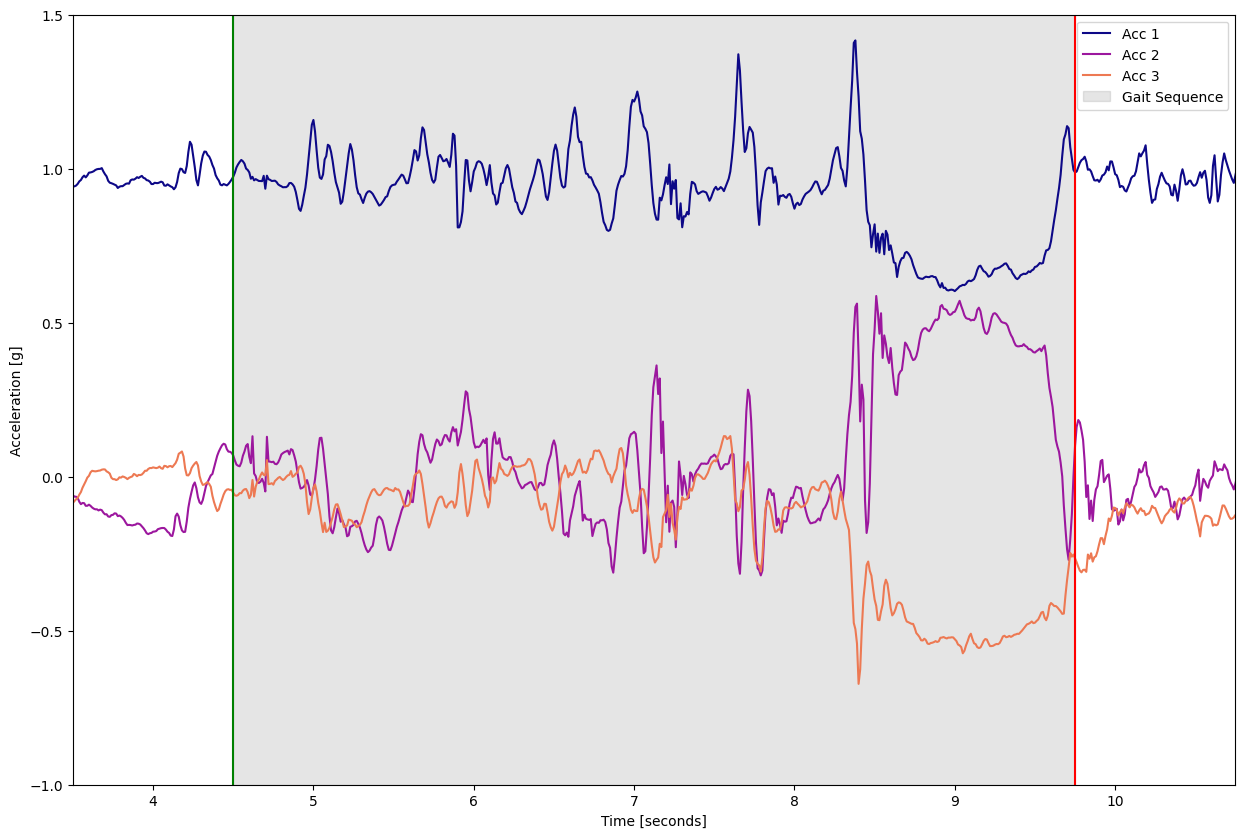

In [16]:
# Display the first detected gait sequence
print(f"First gait sequence:")
print(f"Start Time: {gait_sequences[0]['Start']} seconds")
print(f"End Time: {gait_sequences[0]['End']} seconds")

# Create a figure and axis for plotting the raw data from the lower back
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the acceleration data with different colors from the plasma colormap for each axis
for i in range(3):
    ax.plot(time_seconds, acceleration_data[:, i], color=plt.cm.plasma(i / 3), label=f'Acc {i + 1}')

# Plot the first element of gait sequences if they exist
if gait_sequences:
    first_gait_sequence = gait_sequences[0]
    ax.axvspan(first_gait_sequence['Start'], first_gait_sequence['End'], alpha=0.2, color='grey', label='Gait Sequence')
    plt.axvline(gait_sequences[0]['Start'], color="g")
    plt.axvline(gait_sequences[0]['End'], color="r")
    # Set x-axis limits
    start_limit = first_gait_sequence['Start'] - 1
    end_limit = first_gait_sequence['End'] + 1
    ax.set_xlim(start_limit, end_limit)

ax.set_ylim(-1, 1.5)
ax.set_xlabel('Time [seconds]')
ax.set_ylabel('Acceleration [g]')

# Add legend and show the plot
ax.legend()
plt.show()